In [32]:
from Bio import SeqIO, Seq
import seaborn, matplotlib
import matplotlib.pyplot as plt
import csv

In [2]:
def get_seq(start, strand, genome='Genome Info/U18466.2.fasta', extend=100):
    if genome.startswith('Genome'):
        for rec in SeqIO.parse(open(genome), 'fasta'):
            genome = str(rec.seq)
    if strand == '+':
        return genome[start-1-extend : start+extend]
    return str(Seq.reverse_complement(genome[start-1-extend : start+extend]))

def get_overlapped(start, end, strand, tss_poss):
    for tss_pos, tss_strand in tss_poss:
        if tss_strand == strand and start <= tss_pos and end >= tss_pos:
            return tss_pos, tss_strand
    return False

def count_lgaps(seq):
    n = 0
    for x in seq:
        if x == '-':
            n += 1
        else:
            return n
    return n

def get_upstream_perfect_match(seq, ref, start, end, tss, strand, n_inside=5, trimG=True):
    if strand == '+':
        ref_upstream = ref[(tss-start): (tss-start)+10]
        ref_up = {'upstream': ref[:tss-start], 'TSS': ref[tss-start], 
                  'downstream': seq[tss-start+1:tss-start+n_inside]}
    else:
        ref_upstream = ref[(end-tss): (end-tss)+10]
        ref_up = {'upstream': ref[:end-tss], 'TSS': ref[end-tss], 'downstream': seq[end-tss+1:end-tss+n_inside]}
    try:
        seq_i = seq.index(ref_upstream)
    except ValueError:
        raise ValueError("No perfect match found for", ref_upstream)
    seq_up = {'upstream': seq[:seq_i], 'TSS': seq[seq_i], 'downstream': seq[seq_i+1:seq_i+n_inside]}
    if trimG:
        if seq_up['upstream'].startswith('G'):
            seq_up['upstream'] = seq_up['upstream'][1:]
            ref_up['upstream'] = ref_up['upstream'][1:]
    
    return {'seq': seq_up, 'ref': ref_up}

def get_upstream_aln(seq, ref, start, end, tss, strand, downstream=5):
    alns = pairwise2.align.globalms(seq, ref, 1, -10, -10, -0.1, one_alignment_only=True)
    seq_aln, ref_aln = alns[0][:2]
    if strand == '+':
        ref_start = start - len([x for x in ref_aln.strip('-') if x == '-'])
        seq_start = ref_start
        if seq_aln.startswith('-'):
            seq_start = ref_start + count_lgaps(seq_aln)
        shift = tss - seq_start
    else:
        ref_end = end + len([x for x in ref_aln.strip('-') if x == '-'])
        seq_end = ref_end
        if seq_aln.startswith('-'):
            seq_end = ref_end - count_lgaps(seq_aln)
        shift = seq_end - tss
    return seq[:(shift+downstream)][::-1], shift

def count_mismatches(seq, ref, first=25):
    if seq.startswith('G'):
        seq = seq[1:]
        ref = ref[1:]
    return len([i for i in range(first) if seq[i] != ref[i]])

def get_ref(genome, tss, strand, additional=10):
    if strand == '+':
        return genome[tss-1-additional:tss-1] + ' ' + genome[tss-1] + ' ' + genome[tss:tss+additional]
    else:
        seq = genome[tss-1-additional:tss-1] + ' ' + genome[tss-1] + ' ' + genome[tss:tss+additional]
        return str(Seq.reverse_complement(seq))

In [3]:
for rec in SeqIO.parse(open('Genome Info/U18466.2.fasta'), 'fasta'):
    genome = str(rec.seq)

In [4]:
ref = 'ACCCCCAAGAGAGAGGTTGGCTCACTATAGCTAGCTATAGCTAGCTATAGCTAGTAGGCAATCTACCAGTACTTTGTGGAC'
seq = 'GAGAGAGAGAGAGAGGTTGGCTCACTATAGCTAGCTATAGCTAGCTATAGCTAGTAGGCAATCTACCAGTACTTTGTGGAC'
print(get_upstream_perfect_match(seq, ref, 1, 100, 10, '+'))
print(get_upstream_perfect_match(seq, ref, 1, 100, 91, '-'))

{'seq': {'upstream': 'AGAGAGAG', 'TSS': 'A', 'downstream': 'GAGA'}, 'ref': {'upstream': 'CCCCCAAG', 'TSS': 'A', 'downstream': 'GAGA'}}
{'seq': {'upstream': 'AGAGAGAG', 'TSS': 'A', 'downstream': 'GAGA'}, 'ref': {'upstream': 'CCCCCAAG', 'TSS': 'A', 'downstream': 'GAGA'}}


In [75]:
tss_positions = {(int(x.split()[2]), x.split()[-1]): x.split()[3] for x in \
                 open('Genome Info/158_pTSS_NA_pTSS_check_NEW_incl_alt_TSSs.bed')}
tss_additions = {}

for file in ['Early-5h/S1_comparison.txt', 'Early-5h/S2_comparison.txt', 
             'Late-16h/S3_comparison.txt', 'Late-16h/S4_comparison.txt']:
    repl = file.split('/')[1].split('_')[0]
    for row in csv.DictReader(open(file), delimiter='\t'):
        start, end, strand = int(row['start'])+1, int(row['end']), row['strand']
        tss_pos_strand = get_overlapped(start, end, strand, tss_positions)
        if tss_pos_strand:
            tss_pos, tss_strand = tss_pos_strand
            gene = tss_positions[tss_pos_strand]
            seq, ref = row['sequenced'], row['reference']
            if gene not in tss_additions:
                tss_additions[gene] = {}
                tss_additions[gene]['seq'] = get_ref(genome, tss_pos, tss_strand)
            if repl not in tss_additions[gene]:
                tss_additions[gene][repl] = {'downstream not found': 0, 
                                             'perfect matches': 0,
                                             'perfect matches but longer': 0,
                                             'long with non perfect matches': 0,
                                             'total added sequences': 0,
                                             'upstream sequences': {}}
            try:
                upstream = get_upstream_perfect_match(seq, ref, start, end, tss_pos, strand)
                if upstream['seq']['upstream'] == '':
                    tss_additions[gene][repl]['perfect matches'] += 1
                else:
                    seq_up = upstream['seq']['upstream']
                    if seq_up == upstream['ref']['upstream']:
                        tss_additions[gene][repl]['perfect matches but longer'] += 1
                    elif len(seq_up) > 5 and \
                            seq_up[-4:] == tss_additions[gene]['seq'].split()[0][-4:]:
                        tss_additions[gene][repl]['long with non perfect matches'] += 1
                    else:
                        tss_additions[gene][repl]['total added sequences'] += 1
                        if seq_up not in tss_additions[gene][repl]['upstream sequences']:
                            tss_additions[gene][repl]['upstream sequences'][seq_up] = 0
                        tss_additions[gene][repl]['upstream sequences'][seq_up] += 1
            except ValueError:
                tss_additions[gene][repl]['downstream not found'] += 1

In [77]:
n_gene = 0
at_genes = []
for gene in tss_additions:
    additional = False
    for repl in ['S1', 'S2', 'S3', 'S4']:
        if repl in tss_additions[gene]:
            total = sum([x for x in tss_additions[gene][repl].values() if type(x) is int])
            n_added = tss_additions[gene][repl]['total added sequences']
            added_fraction = n_added / total * 100
            if added_fraction >= 10 and total >= 10:
                print(n_gene, gene, repl, tss_additions[gene]['seq'], '%.1f%%' % added_fraction, total, sep='\t')
                seq_n = list(tss_additions[gene][repl]['upstream sequences'].items())
                seq_n.sort(key=lambda x: x[1], reverse=True)
                i = 1
                for seq, count in seq_n:
                    for j in range(count):
                        sizes[repl].append(len(seq))
                    if len(seq) > 10 or count < 2:
                        continue
                    print(seq, count, len(seq), sep='\t')
                    if i > 10:
                        break
                    i += 1
                if ('AT' in [x[0] for x in seq_n] and 'ATAT' in [x[0] for x in seq_n]):
                    at_genes.append((gene, repl))
                elif ('TA' in [x[0] for x in seq_n] and 'TATA' in [x[0] for x in seq_n]):
                    at_genes.append((gene, repl))                    
                print()

0	I73R	S1	AAAAAGAAGT A TACTCTCCTT	18.7%	30170
AT	4833	2
C	269	1
ATAT	193	4
A	68	1
CAT	31	3
G	16	1
TAT	14	3
AA	14	2
AAT	8	3
TT	6	2
ATATAT	5	6

0	I73R	S2	AAAAAGAAGT A TACTCTCCTT	18.8%	30441
AT	4956	2
C	319	1
ATAT	189	4
CAT	27	3
AA	20	2
A	15	1
G	12	1
TG	6	2
TT	6	2
TAT	6	3
ATATAT	3	6

0	I73R	S3	AAAAAGAAGT A TACTCTCCTT	18.4%	24712
AT	3853	2
C	343	1
ATAT	135	4
CAT	31	3
A	12	1
G	10	1
TT	7	2
TAT	6	3
ATATAT	6	6
AA	5	2
AAT	5	3

0	I73R	S4	AAAAAGAAGT A TACTCTCCTT	18.6%	24037
AT	3769	2
C	362	1
ATAT	140	4
A	21	1
CAT	20	3
G	11	1
AA	8	2
TT	8	2
ATATAT	5	6
N	5	1
TAT	3	3

0	J268L	S1	TTTTTTTAGT A AAGACTTTTA	16.2%	1362
A	166	1
AA	37	2
AAA	6	3
C	2	1

0	J268L	S2	TTTTTTTAGT A AAGACTTTTA	15.7%	1365
A	176	1
AA	23	2
AAA	6	3
C	3	1
AAAA	2	4

0	J268L	S3	TTTTTTTAGT A AAGACTTTTA	10.3%	1118
A	83	1
AA	17	2
AAA	5	3

0	J268L	S4	TTTTTTTAGT A AAGACTTTTA	10.3%	936
A	74	1
AA	8	2
AAA	6	3
GTAGT	2	5

0	C105R	S1	TTCCTAGAGG A GAATTAGTTT	37.5%	1319
AG	449	2
AGA	13	3
C	9	1
CAG	8	3
AGAGA	4	5

0	C105R	S2	TTCCTAGAGG A GAATTAGTTT	38.3%

TAT	35	3
C	30	1
CAT	10	3
ATA	9	3
T	8	1
TATAT	3	5
TT	3	2
AA	3	2
ATATAT	2	6

0	EP364R	S4	CACGTATTTA A TATATACTAC	10.9%	4774
AT	407	2
ATAT	31	4
C	21	1
TAT	21	3
ATA	7	3
T	7	1
CAT	5	3
TT	3	2
TATAT	2	5

0	C257L	S2	ATTGTTTAAC A TAGGAGGAAA	31.2%	16
AT	4	2

0	C257L	S3	ATTGTTTAAC A TAGGAGGAAA	22.5%	17971
AT	2274	2
ATAT	1316	4
ATATAT	109	6
T	54	1
G	52	1
TT	35	2
TAT	31	3
TG	23	2
CAT	22	3
ATATATAT	21	8
A	20	1

0	C257L	S4	ATTGTTTAAC A TAGGAGGAAA	21.8%	16310
AT	2042	2
ATAT	1131	4
ATATAT	79	6
G	66	1
T	44	1
TT	26	2
CATAT	26	5
ATATATAT	23	8
TG	16	2
CAT	12	3
TAT	10	3

0	B385R	S3	TAAGGGGGGT A TAACAATGGA	21.1%	4256
AT	811	2
ATAT	23	4
C	14	1
TGAT	7	4
ATA	6	3
GAT	5	3
CAT	3	3
CGAT	2	4
TT	2	2

0	B385R	S4	TAAGGGGGGT A TAACAATGGA	20.8%	5204
AT	928	2
ATAT	55	4
C	27	1
GAT	12	3
ATA	5	3
AA	4	2
ATATAT	4	6
CAT	4	3
ATAAT	2	5
TGAT	2	4

0	C717R	S3	GCTTATAAAT A TACCATGACA	13.3%	1309
ATAT	127	4
ATATAT	19	6
C	12	1
ATAAT	2	5

0	C717R	S4	GCTTATAAAT A TACCATGACA	14.1%	1488
ATAT	145	4
ATATAT	32	6
C	14	1
CAT	2	3
ATAAT	2	5
TT	2	2

In [92]:
repls = ['S1', 'S2', 'S3', 'S4']
sizes = {x: [] for x in repls}
seqs = {x: [] for x in repls}
added_seqs = {x: 0 for x in repls}

for gene in tss_additions:
    for repl in repls:
        if repl in tss_additions[gene]:
            total = sum([x for x in tss_additions[gene][repl].values() if type(x) is int])
            n_added = tss_additions[gene][repl]['total added sequences']
            added_seqs[repl] += n_added
            for i in range(total - n_added):
                sizes[repl].append(0)
            for seq,count in tss_additions[gene][repl]['upstream sequences'].items():
                for i in range(count):
                    sizes[repl].append(len(seq))
                    seqs[repl].append(seq)

In [94]:
print('count', *repls, sep='\t')
last = 11
for i in range(0, last+1):
    if i == last:
        counts = [len([y for y in sizes[x] if y >= last]) for x in repls]
    else:
        counts = [sizes[x].count(i) for x in repls]
    print(i, *counts, sep='\t')

count	S1	S2	S3	S4
0	316286	313280	2111802	1814784
1	4593	4479	22344	20393
2	7828	8143	213599	183168
3	2169	2136	15128	13373
4	856	877	25603	22481
5	211	239	5491	4758
6	101	118	3088	2757
7	21	21	595	515
8	26	23	605	567
9	11	7	111	103
10	12	7	96	107
11	670	661	3801	3433


In [96]:
print('seq', *repls, *repls, sep='\t')

seqs_all = set()
for repl in repls:
    seqs_all.update(set(seqs[repl]))

for seq in seqs_all:
    counts = [seqs[x].count(seq) for x in repls]
    percs = [counts[i]/added_seqs[x] for i,x in enumerate(repls)]
    if sum([1 if percs[i] >= 0.02 else 0 for i in range(4)]) > 0:
        print(seq, *counts, *percs, sep='\t')

seq	S1	S2	S3	S4	S1	S2	S3	S4
AG	1006	1071	870	1016	0.06097708813189478	0.06408952187182096	0.002995238603461394	0.004037273251077864
ACT	1478	1376	3387	2707	0.08958661655958298	0.08234097301178864	0.01166077373554453	0.010756790049869862
G	427	468	1674	1625	0.0258819250818281	0.028005505355753694	0.005763252209418821	0.006457252985237727
AT	5424	5611	206997	176867	0.3287671232876712	0.3357668601519957	0.7126498910352853	0.7028153623015636
A	2002	1810	5045	4649	0.12134804218693175	0.10831189037161151	0.0173689410970836	0.01847370407899704
C	2000	2114	14429	13036	0.12122681537156019	0.12650350068816946	0.04967620437855685	0.05180107687111323
AA	700	758	2384	2312	0.042429385380046064	0.04535934414457543	0.008207642334082717	0.009187180862688998
ATAT	633	665	23070	20247	0.0383682870650988	0.03979414756747053	0.07942546503661421	0.08045538534898969


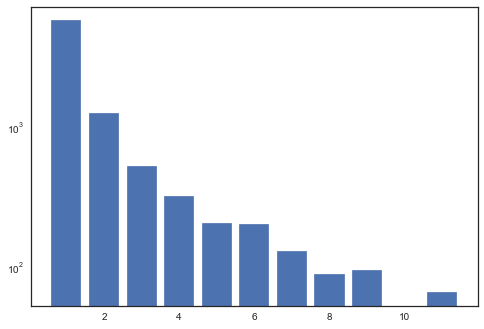

In [88]:
matplotlib.rcParams['font.family'] = "arial"

x_y = sorted(list(size2count.items()), key=lambda x: x[1], reverse=True)[:10]
X = [x[0] for x in x_y]
Y = [x[1] for x in x_y]

plt.style.use('seaborn-white')
plt.bar(X, Y)#, color='grey')
plt.yscale('log')

In [8]:
print(sorted(set(at_genes)))

[('A104R', 'S3'), ('A104R', 'S4'), ('A118R', 'S3'), ('A118R', 'S4'), ('A137R', 'S1'), ('B125R', 'S3'), ('B125R', 'S4'), ('B385R', 'S3'), ('B385R', 'S4'), ('B407L', 'S3'), ('B407L', 'S4'), ('C129R', 'S3'), ('C129R', 'S4'), ('C257L', 'S2'), ('C257L', 'S3'), ('C257L', 'S4'), ('C475L', 'S4'), ('C717R', 'S4'), ('C84L', 'S3'), ('C84L', 'S4'), ('CP530R', 'S3'), ('CP530R', 'S4'), ('D117L', 'S3'), ('D117L', 'S4'), ('D339L', 'S1'), ('D339L', 'S2'), ('D339L', 'S3'), ('D339L', 'S4'), ('D345L', 'S2'), ('D79L', 'S4'), ('DP42R', 'S1'), ('DP42R', 'S2'), ('DP42R', 'S3'), ('DP42R', 'S4'), ('DP60R', 'S1'), ('DP71L', 'S3'), ('DP71L', 'S4'), ('E111R', 'S3'), ('E111R', 'S4'), ('E120R_L', 'S3'), ('E120R_L', 'S4'), ('E184L', 'S3'), ('E184L', 'S4'), ('EP364R', 'S3'), ('EP364R', 'S4'), ('EP402R', 'S3'), ('EP402R', 'S4'), ('F317L', 'S3'), ('F317L', 'S4'), ('G1340L', 'S3'), ('G1340L', 'S4'), ('H124R', 'S3'), ('H124R', 'S4'), ('H233R', 'S3'), ('H233R', 'S4'), ('H359L', 'S1'), ('H359L', 'S2'), ('H359L', 'S4'), ('I2

In [97]:
late_genes = [x.strip() for x in open('../LIST_54_LATE')]
early_genes = [x.strip() for x in open('../LIST_36_EARLY')]

In [98]:
at_gene_names = set([x[0] for x in at_genes])
print(len(at_gene_names))
i = 1
for gene in tss_additions:
    if gene in late_genes:
        phase = 'late'
    elif gene in early_genes:
        phase = 'early'
    else:
        phase = 'not_known'
    if gene in at_gene_names:# and phase in ('early', 'not_known'):
        #print('AT genes:', gene, tss_additions[gene]['seq'], phase, sep='\t')
        print('>%s_%s' % (i, phase), tss_additions[gene]['seq'].replace(' ', ''), sep='\n')
        i += 1
    #else:
        #print('Not:', tss_additions[gene]['seq'], phase)

35
>1_early
AAAAAGAAGTATACTCTCCTT
>2_early
AGAATATATTATAGATATGAT
>3_early
CTATATATTTATAATACAAAT
>4_late
TTTGTTAAGAATAAATGGTTG
>5_early
TTGTAAAAAAATATGCCTACT
>6_not_known
ATGAAAATGCATATAGCCCGC
>7_late
CATAATATACATAGAATGCCT
>8_not_known
TTAATATTAAATATAAAATGT
>9_early
AGCGGTAATAATAATTGATAC
>10_late
TTTGAGATTAATATAACTGTT
>11_not_known
ATTTATATGTATACAACTGTA
>12_not_known
GAGCTTAAACATATTCGCCAA
>13_late
TTTTTATTAAATATGGCGGTT
>14_not_known
TATACCGGGTATAATGGATTT
>15_late
TTAGTTTTTTATACAAGAATG
>16_not_known
TTGCCATTTTATAGAATGTAC
>17_not_known
AGGTATTGTTATAGTGATGGC
>18_not_known
TTATGTTATTATAGGTATTAA
>19_late
ATACTGTTGTATATTATAAGA
>20_not_known
GCTGCTATTTATATGGATCAG
>21_late
TCTAATACACATATTCCCTAC
>22_not_known
TTTGGAAATCATATAGCCATA
>23_late
AAATTATAAAATAATAAGAAG
>24_late
AAAAATCATTATAAAATGAAT
>25_not_known
TTTTGTTTTAATATTTGCATG
>26_late
TGGGATCCTTATAACGAGTCA
>27_not_known
AATTATAGTTATATACAAATA
>28_not_known
TTTTAATAGTATATACAGGAT
>29_not_known
TAAATAAACTATAAATGAAAA
>30_late
CACGTATTTAATATATACTAC
>